# CS 316 : Introduction to Deep Learning - Fall 2024
## Lab 07 : Gradient Descent and Backpropagation
### Dr. Abdul Samad

# Instructions

1. Make a copy of this notebook on google colab at start of the lab.

2. Please rename your notebook as *Lab_7_aa1234.ipynb* before starting the lab. Notebooks which do not follow appropriate naming convention will not be graded.

3. You have to submit this lab during the lab timings. You are allowed to submit till 11:59 PM on the day of your lab with a 30% penalty. No submissions will be accepted afterwards.

4. Use of AI is strictly prohibited. Anyone caught using Any AI tool during lab or while grading will be immediately reported to OCVS without any further discussion.

5. At the end of the lab, download the notebook (ipynb extension file) and upload it on canvas as a file. Submitting link to notebook or any other file will not be accepted.

6. Each task has points assigned to it. Total Lab is of 100 points.

7. Use of for loops is strictly prohibited.

8. For every theoretical question, there is a separate cell given at the end. You have to write your answer there.

9. If you have any questions, please feel free to reach out to the course instructor or RA.

## Task Overview


We will continue with where we left in last lab. In this lab we will first work on Stochastic Gradient Descent and then move to momentum and Adam Optimization. At the end we will work on Backpropagration. Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Let's start with importing Libraries first

In [308]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import math

In [309]:
# Let's create our training data of 30 pairs {x_i, y_i}
# We'll try to fit the Gabor model to these data
data = np.array([[-1.920e+00,-1.422e+01,1.490e+00,-1.940e+00,-2.389e+00,-5.090e+00,
                 -8.861e+00,3.578e+00,-6.010e+00,-6.995e+00,3.634e+00,8.743e-01,
                 -1.096e+01,4.073e-01,-9.467e+00,8.560e+00,1.062e+01,-1.729e-01,
                  1.040e+01,-1.261e+01,1.574e-01,-1.304e+01,-2.156e+00,-1.210e+01,
                 -1.119e+01,2.902e+00,-8.220e+00,-1.179e+01,-8.391e+00,-4.505e+00],
                  [-1.051e+00,-2.482e-02,8.896e-01,-4.943e-01,-9.371e-01,4.306e-01,
                  9.577e-03,-7.944e-02 ,1.624e-01,-2.682e-01,-3.129e-01,8.303e-01,
                  -2.365e-02,5.098e-01,-2.777e-01,3.367e-01,1.927e-01,-2.222e-01,
                  6.352e-02,6.888e-03,3.224e-02,1.091e-02,-5.706e-01,-5.258e-02,
                  -3.666e-02,1.709e-01,-4.805e-02,2.008e-01,-1.904e-01,5.952e-01]])


This is what our model looks like:

<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1QmwvFkOC5xdMCutwDoIeAQo6V0uo2uKC)
Figure: 1
</center>


It's already coded below.

In [310]:
def model(phi,x):
  sin_component = np.sin(phi[0] + 0.06 * phi[1] * x)
  gauss_component = np.exp(-(phi[0] + 0.06 * phi[1] * x) * (phi[0] + 0.06 * phi[1] * x) / 32)
  y_pred= sin_component * gauss_component
  return y_pred

In [311]:
# This function plots the model
def draw_model(data,model,phi,title=None):
  x_model = np.arange(-15,15,0.1)
  y_model = model(phi,x_model)

  fix, ax = plt.subplots()
  ax.plot(data[0,:],data[1,:],'bo')
  ax.plot(x_model,y_model,'m-')
  ax.set_xlim([-15,15]);ax.set_ylim([-1,1])
  ax.set_xlabel('x'); ax.set_ylabel('y')
  if title is not None:
    ax.set_title(title)
  plt.show()

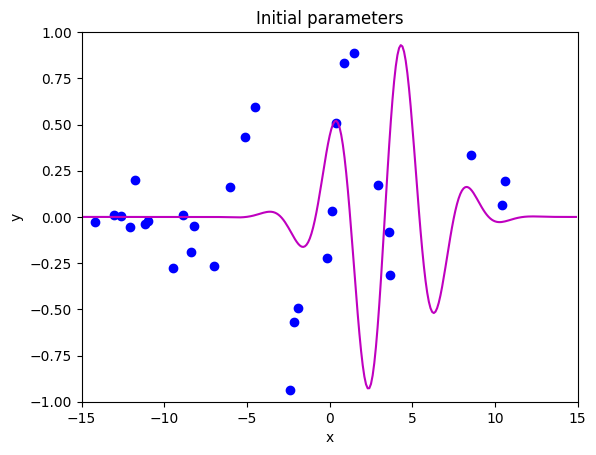

In [312]:
# Initialize the parameters and draw the model
phi = np.zeros((2,1))
phi[0] =  -5     # Horizontal offset
phi[1] =  25     # Frequency
draw_model(data,model,phi, "Initial parameters")


Loss function and its plotting function

In [313]:
def compute_loss(data_x, data_y, model, phi):
  pred_y = model(phi, data_x)
  loss = np.sum((pred_y-data_y)*(pred_y-data_y))
  return loss

def draw_loss_function(compute_loss, data,  model, phi_iters = None):
  # Define pretty colormap
  my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
  my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
  r = np.floor(my_colormap_vals_dec/(256*256))
  g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
  b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
  my_colormap = ListedColormap(np.vstack((r,g,b)).transpose()/255.0)

  # Make grid of offset/frequency values to plot
  offsets_mesh, freqs_mesh = np.meshgrid(np.arange(-10,10.0,0.1), np.arange(2.5,22.5,0.1))
  loss_mesh = np.zeros_like(freqs_mesh)
  # Compute loss for every set of parameters
  for idslope, slope in np.ndenumerate(freqs_mesh):
     loss_mesh[idslope] = compute_loss(data[0,:], data[1,:], model, np.array([[offsets_mesh[idslope]], [slope]]))

  fig,ax = plt.subplots()
  fig.set_size_inches(8,8)
  ax.contourf(offsets_mesh,freqs_mesh,loss_mesh,256,cmap=my_colormap)
  ax.contour(offsets_mesh,freqs_mesh,loss_mesh,20,colors=['#80808080'])
  if phi_iters is not None:
    ax.plot(phi_iters[0,:], phi_iters[1,:],'go-')
  ax.set_ylim([2.5,22.5])
  ax.set_xlabel('Offset $\phi_{0}$'); ax.set_ylabel('Frequency, $\phi_{1}$')
  plt.show()

Now let's compute the gradient vector for a given set of parameters:

\begin{equation}
\frac{\partial L}{\partial \boldsymbol\phi} = \begin{bmatrix}\frac{\partial L}{\partial \phi_0} \\\frac{\partial L}{\partial \phi_1} \end{bmatrix}.
\end{equation}

In [314]:
# These came from writing out the expression for the sum of squares loss and taking the
# derivative with respect to phi0 and phi1. It was a lot of hassle to get it right!
def gabor_deriv_phi0(data_x,data_y,phi0, phi1):
    x = 0.06 * phi1 * data_x + phi0
    y = data_y
    cos_component = np.cos(x)
    sin_component = np.sin(x)
    gauss_component = np.exp(-0.5 * x *x / 16)
    deriv = cos_component * gauss_component - sin_component * gauss_component * x / 16
    deriv = 2* deriv * (sin_component * gauss_component - y)
    return np.sum(deriv)

def gabor_deriv_phi1(data_x, data_y,phi0, phi1):
    x = 0.06 * phi1 * data_x + phi0
    y = data_y
    cos_component = np.cos(x)
    sin_component = np.sin(x)
    gauss_component = np.exp(-0.5 * x *x / 16)
    deriv = 0.06 * data_x * cos_component * gauss_component - 0.06 * data_x*sin_component * gauss_component * x / 16
    deriv = 2*deriv * (sin_component * gauss_component - y)
    return np.sum(deriv)

def compute_gradient_descent(data_x, data_y, phi):
    dl_dphi0 = gabor_deriv_phi0(data_x, data_y, phi[0],phi[1])
    dl_dphi1 = gabor_deriv_phi1(data_x, data_y, phi[0],phi[1])
    # Return the gradient
    return np.array([[dl_dphi0],[dl_dphi1]])

We can check we got this right using a trick known as **finite differences**.  If we evaluate the function and then change one of the parameters by a very small amount and normalize by that amount, we get an approximation to the gradient, so:

\begin{align}
\frac{\partial L}{\partial \phi_{0}}&\approx & \frac{L[\phi_0+\delta, \phi_1]-L[\phi_0, \phi_1]}{\delta}\\
\frac{\partial L}{\partial \phi_{1}}&\approx & \frac{L[\phi_0, \phi_1+\delta]-L[\phi_0, \phi_1]}{\delta}
\end{align}

We can't do this when there are many parameters;  for a million parameters, we would have to evaluate the loss function two million times, and usually computing the gradients directly is much more efficient.

In [315]:
# Compute the gradient using your function
gradient = compute_gradient_descent(data[0,:],data[1,:], phi)
print("Your gradients: (%3.3f,%3.3f)"%(gradient[0],gradient[1]))
# Approximate the gradients with finite differences
delta = 0.0001
dl_dphi0_est = (compute_loss(data[0,:],data[1,:],model,phi+np.array([[delta],[0]])) - \
                    compute_loss(data[0,:],data[1,:],model,phi))/delta
dl_dphi1_est = (compute_loss(data[0,:],data[1,:],model,phi+np.array([[0],[delta]])) - \
                    compute_loss(data[0,:],data[1,:],model,phi))/delta
print("Approx gradients: (%3.3f,%3.3f)"%(dl_dphi0_est,dl_dphi1_est))

assert np.abs(gradient[0]-dl_dphi0_est) < 0.001
assert np.abs(gradient[1]-dl_dphi1_est) < 0.001


Your gradients: (3.344,0.519)
Approx gradients: (3.344,0.519)


C:\Users\Ahmed Shoaib\AppData\Local\Temp\ipykernel_12428\1253917813.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Your gradients: (%3.3f,%3.3f)"%(gradient[0],gradient[1]))


Now we are ready to perform gradient descent.  We'll this time keep alpha as constant (In last lab we found alpha using line search).

In [316]:
def gradient_descent_step_fixed_learning_rate(phi, data, alpha):
  gradient = compute_gradient_descent(data[0,:],data[1,:], phi)
  phi = phi - alpha * gradient
  return phi

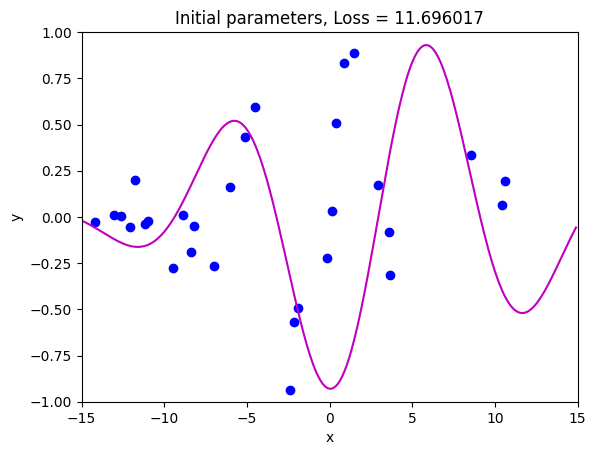

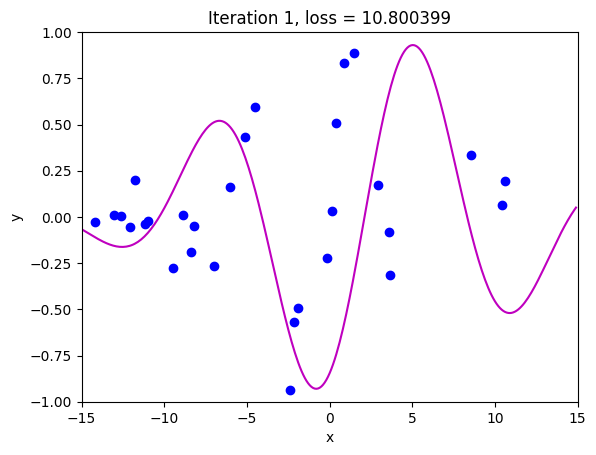

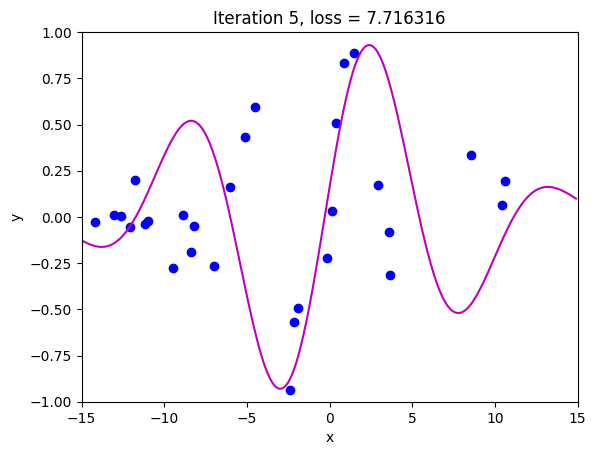

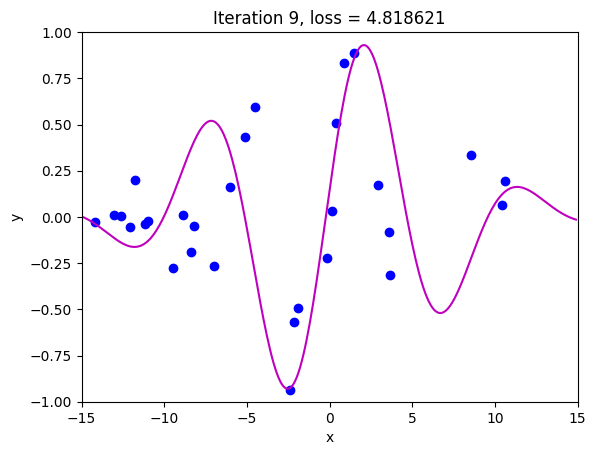

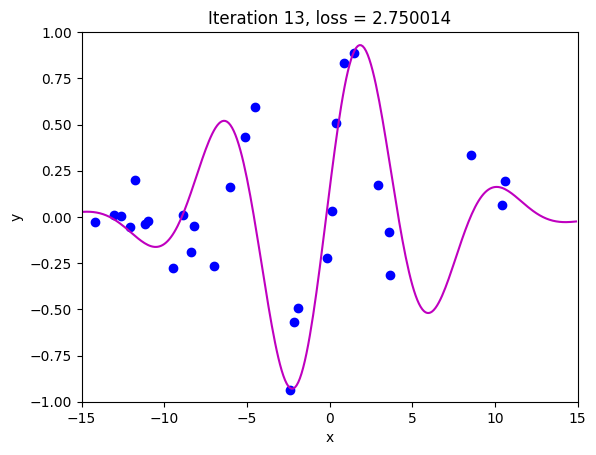

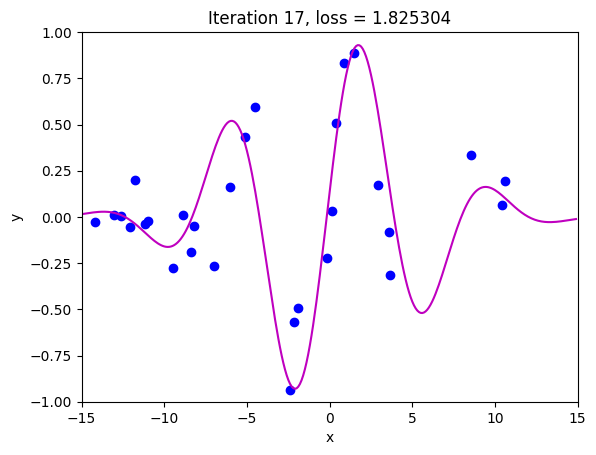

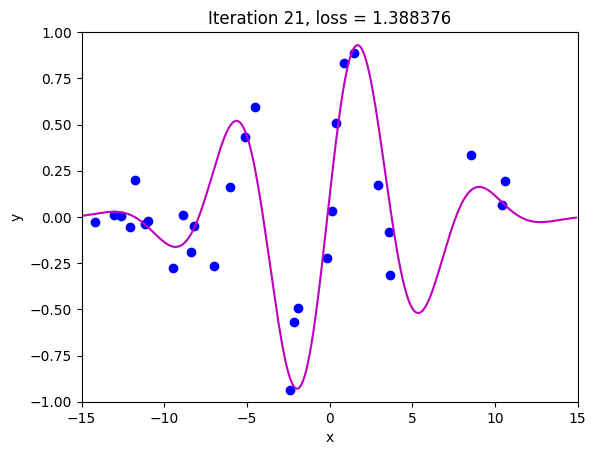

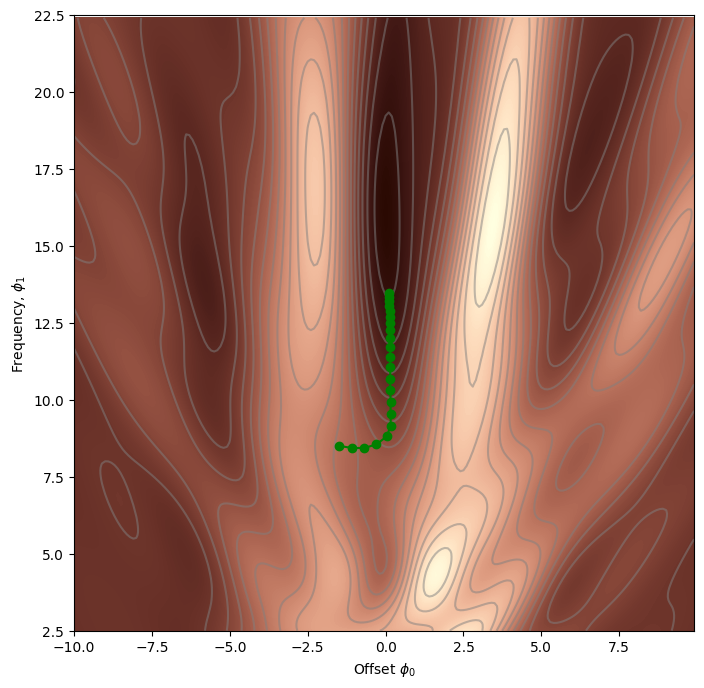

In [317]:
# Initialize the parameters
n_steps = 21
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = -1.5
phi_all[1,0] = 8.5

# Measure loss and draw initial model
loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,0:1])
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Do gradient descent step
  phi_all[:,c_step+1:c_step+2] = gradient_descent_step_fixed_learning_rate(phi_all[:,c_step:c_step+1],data, alpha =0.2)
  # Measure loss and draw model every 4th step
  if c_step % 4 == 0:
    loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2])
    draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))

draw_loss_function(compute_loss, data, model,phi_all)


# Q1: TODO [5 Points]

Experiment with the learning rate, alpha. Make the copy of code given in previous cell. Use the code space given below for this. Make changes to this for answering these questions. After finding answers, write them in text space given below this cell.

    What happens if you set it too large?
    What happens if you set it too small?

In [318]:
# Use this cell for experimentation


Use this cell for writing answers
By setting the learning rate too large there is a high likelihood that the global minimum of the loss function is not reached. 
By setting the learning rate too small it will take a lot of time to reach the global minimum.

# Q2: TODO [15 Points]

#**Stochastic Gradient Descent**
Complete the function given below so that we take a fixed size step of size alpha but only using a subset (batch) of the data at each step. Function np.random.permutation is used to generate a random permutation of the n_data = data.shape[1] indices and then the first n=batch_size of these indices have been selected. Continue this code by then computing the gradient descent from just the data with these indices and then update the gradient.

In [319]:
def stochastic_gradient_descent_step(phi, data, alpha, batch_size):
  n_data = data.shape[1]
  indices = np.random.permutation(n_data)
  # TODO
  phi = phi - alpha * compute_gradient_descent(data[0,indices[:batch_size]],data[1,indices[:batch_size]], phi)
  
  # End TODO
  return phi

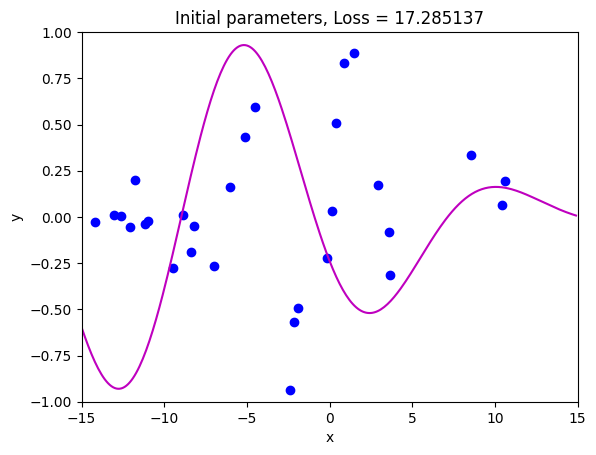

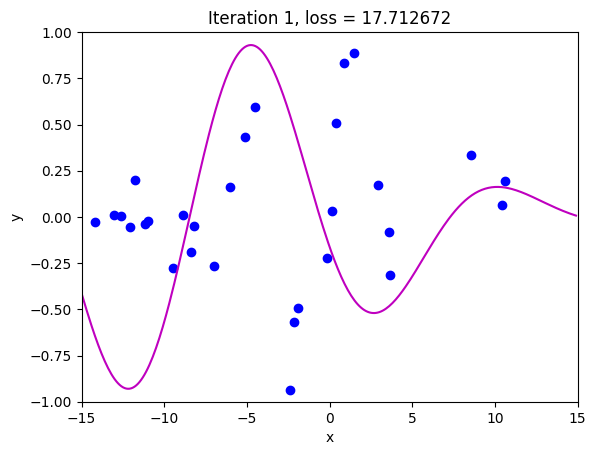

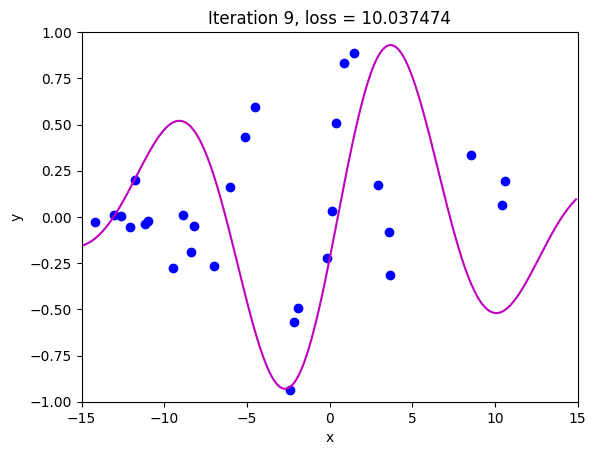

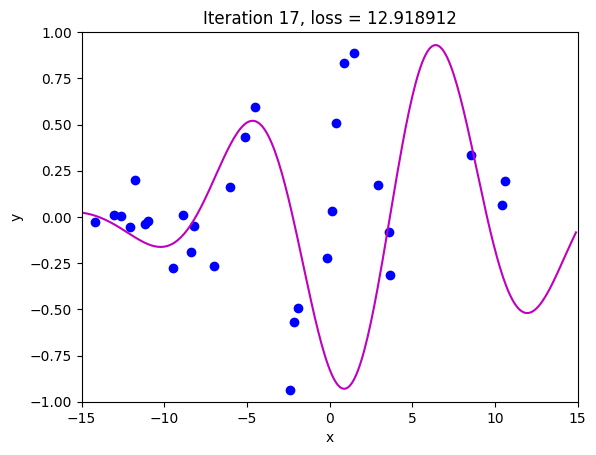

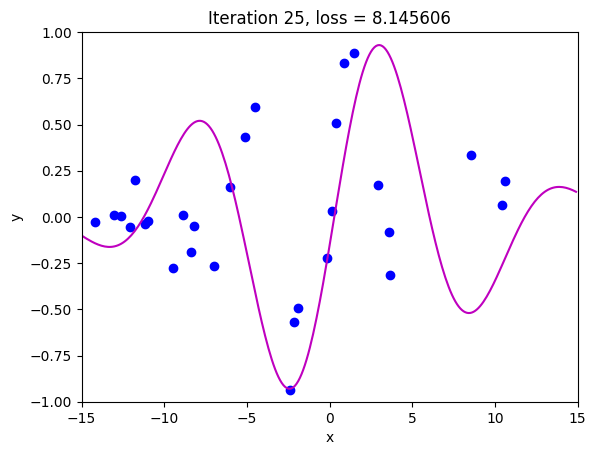

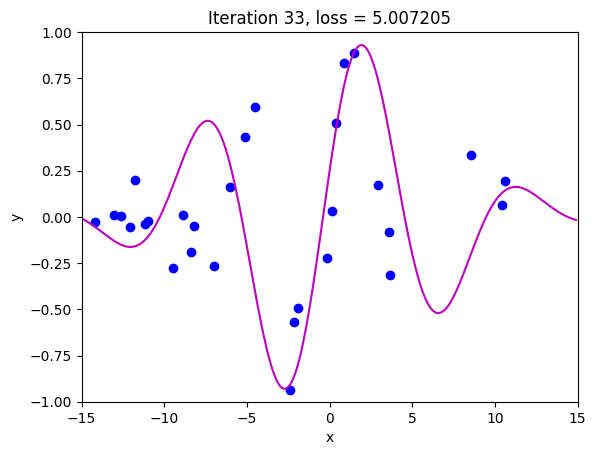

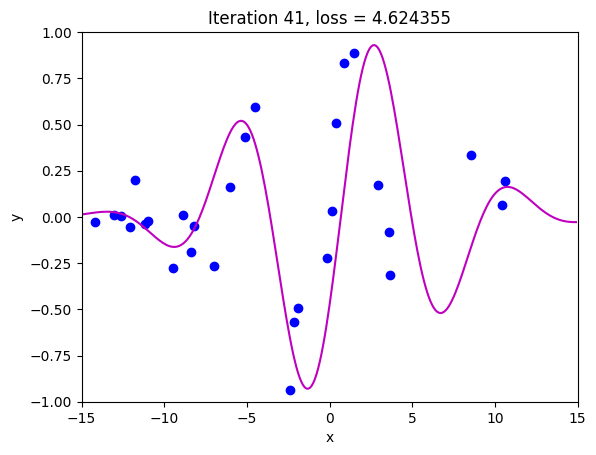

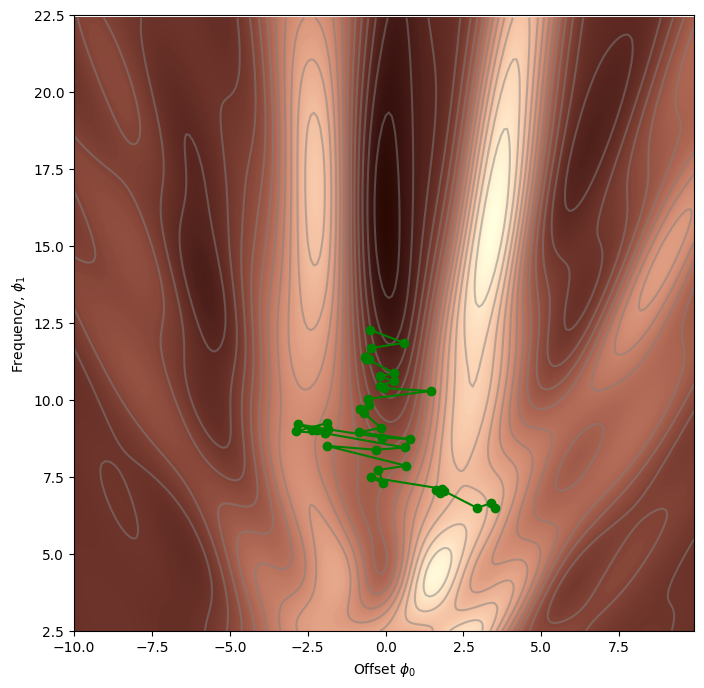

In [320]:
# Set the random number generator so you always get same numbers (disable if you don't want this)
np.random.seed(1)
# Initialize the parameters
n_steps = 41
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = 3.5
phi_all[1,0] = 6.5

# Measure loss and draw initial model
loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,0:1])
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Do gradient descent step
  phi_all[:,c_step+1:c_step+2] = stochastic_gradient_descent_step(phi_all[:,c_step:c_step+1],data, alpha =0.8, batch_size=5)
  # Measure loss and draw model every 8th step
  if c_step % 8 == 0:
    loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2])
    draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))

draw_loss_function(compute_loss, data, model,phi_all)

### If your code in this task is correct then your graph will look like this:


<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1G-NWlcroIcneJfh_ztwTZcTjxeJJ8eSE)
Figure: 10
</center>

# **Momentum**

Let's use momentum now. Below given code cell is standard stochastic gradient descent. We will utilize this to work on momentum.





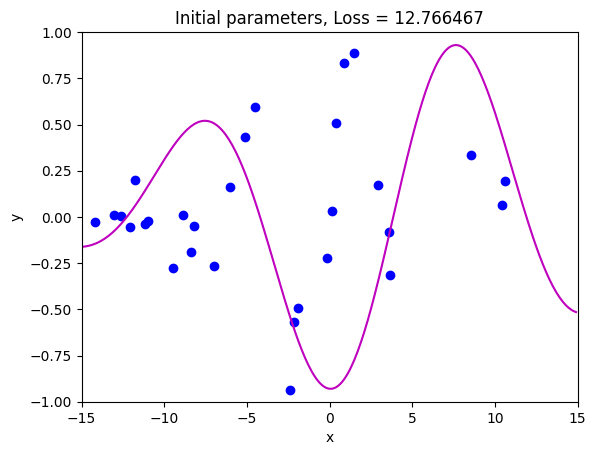

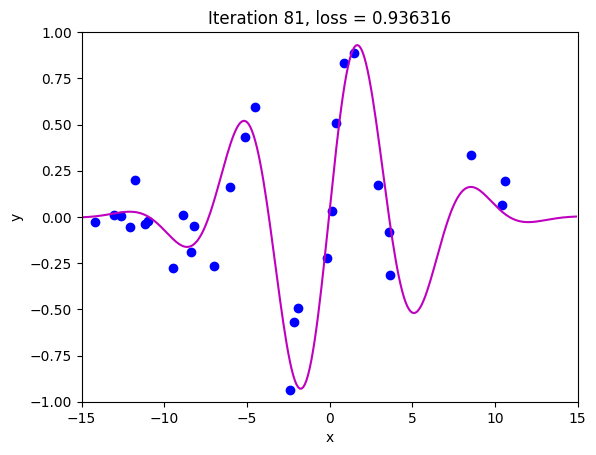

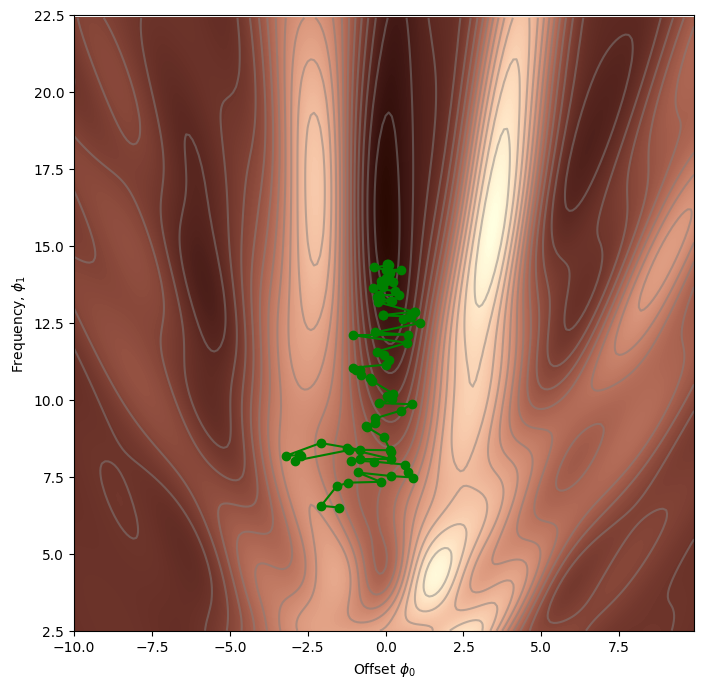

In [321]:
# Set the random number generator so you always get same numbers (disable if you don't want this)
np.random.seed(1)
# Initialize the parameters
n_steps = 81
batch_size = 5
alpha = 0.6
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = -1.5
phi_all[1,0] = 6.5

# Measure loss and draw initial model
loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,0:1])
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Choose random batch indices
  batch_index = np.random.permutation(data.shape[1])[0:batch_size]
  # Compute the gradient
  gradient = compute_gradient_descent(data[0,batch_index], data[1,batch_index], phi_all[:,c_step:c_step+1] )
  # Update the parameters
  phi_all[:,c_step+1:c_step+2] = phi_all[:,c_step:c_step+1] - alpha * gradient

loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2])
draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))
draw_loss_function(compute_loss, data, model,phi_all)

# Q3: TODO [15 Points]

Now let's add momentum.


<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1cFDEd6UulpXrLN0IJcitI4u8eFrhGxLE)
Figure: 2
</center>



This is momentum's equation. Momentum's code is given below but some part is missing. Update it in the code space given below.

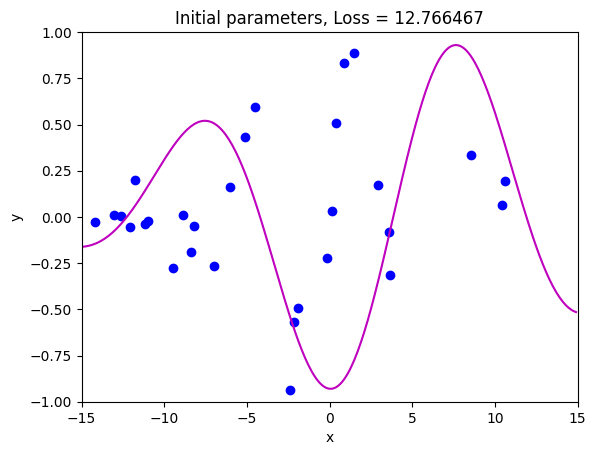

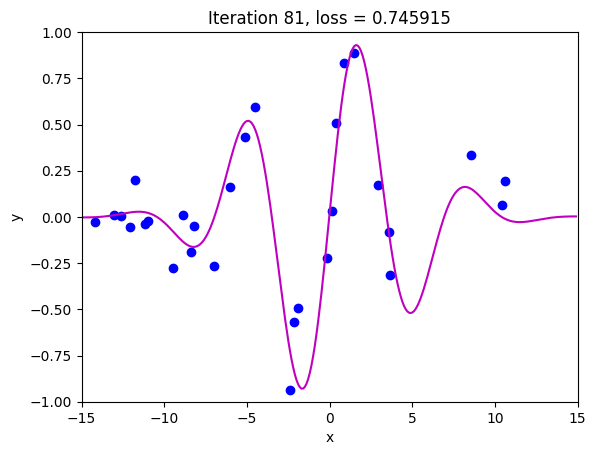

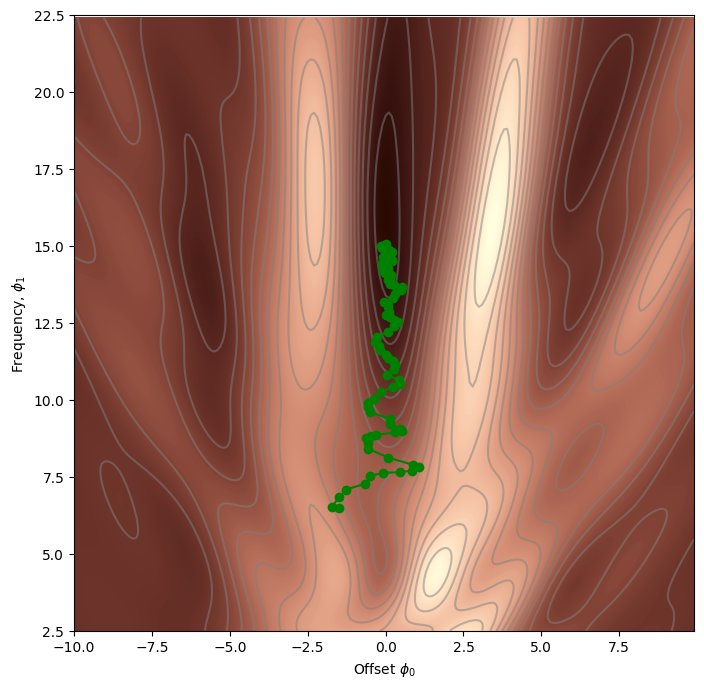

In [322]:
# Set the random number generator so you always get same numbers (disable if you don't want this)
np.random.seed(1)
# Initialize the parameters
n_steps = 81
batch_size = 5
alpha = 0.6
beta = 0.6
momentum = np.zeros([2,1])
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = -1.5
phi_all[1,0] = 6.5

# Measure loss and draw initial model
loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,0:1])
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Choose random batch indices
  batch_index = np.random.permutation(data.shape[1])[0:batch_size]
  # Compute the gradient
  gradient = compute_gradient_descent(data[0,batch_index], data[1,batch_index],  phi_all[:,c_step:c_step+1])
  # TODO -- Use figure 2
  momentum = beta * momentum + (1-beta) * gradient


  # END TODO
  # Update the parameters
  phi_all[:,c_step+1:c_step+2] = phi_all[:,c_step:c_step+1] - alpha * momentum

loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2])
draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))
draw_loss_function(compute_loss, data, model,phi_all)

### If your code in this task is correct then your graph will look like this:


<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1f-ZJfs8QNtfxgc8_Qh1FXfN__e5Amd-k)
Figure: 11
</center>

# Q4: TODO [15 Points]

Finally, we'll try Nesterov momentum

<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1aU6SgI4r36-SnHMpI7lFu9ioZg1F_C9N)
Figure: 3
</center>

Similar to momentum, majority of the code is already there. Just complete it using the equation given here and your understanding of the Nesterov momentum.



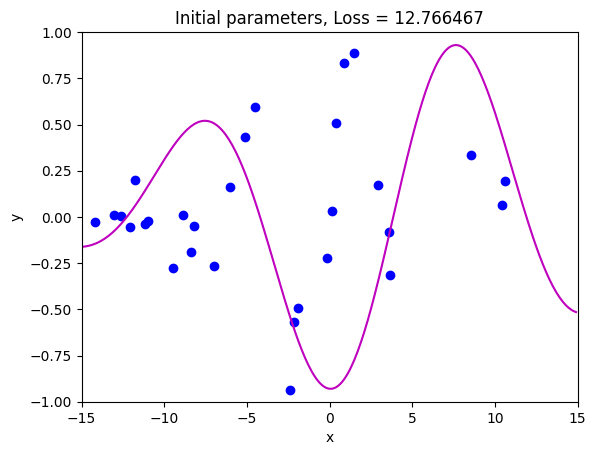

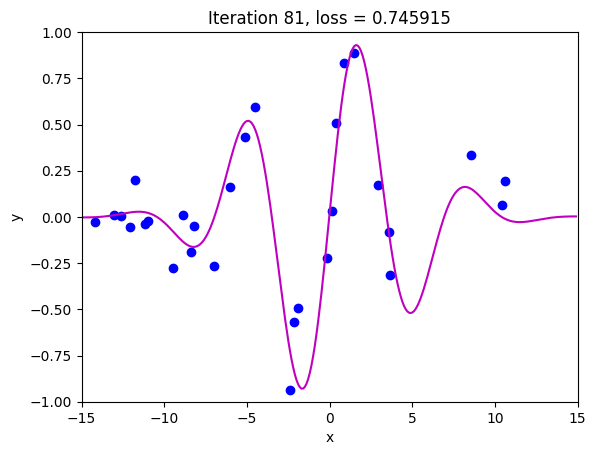

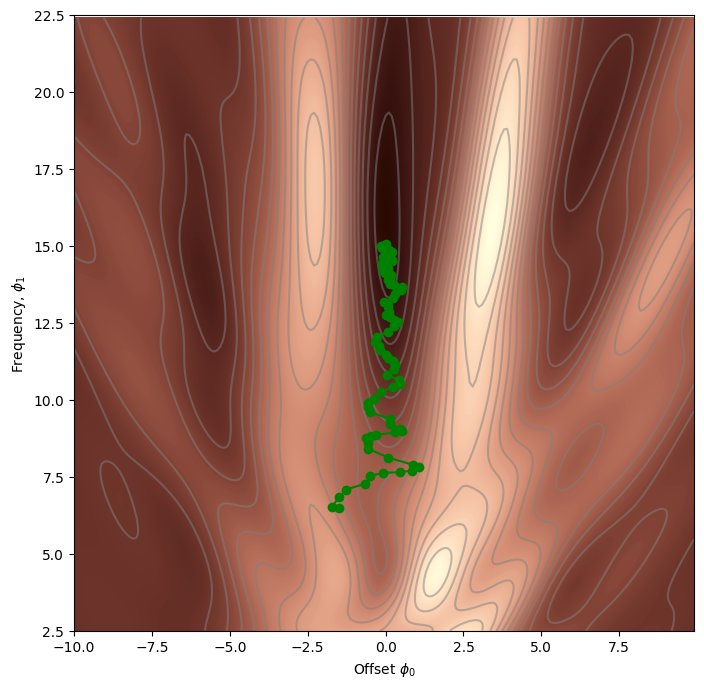

In [323]:
# Set the random number generator so you always get same numbers (disable if you don't want this)
np.random.seed(1)
# Initialize the parameters
n_steps = 81
batch_size = 5
alpha = 0.6
beta = 0.6
momentum = np.zeros([2,1])
phi_all = np.zeros((2,n_steps+1))
phi_all[0,0] = -1.5
phi_all[1,0] = 6.5

# Measure loss and draw initial model
loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,0:1])
draw_model(data,model,phi_all[:,0:1], "Initial parameters, Loss = %f"%(loss))

for c_step in range (n_steps):
  # Choose random batch indices
  batch_index = np.random.permutation(data.shape[1])[0:batch_size]
  # TODO -- Use figure 3
  gradient = compute_gradient_descent(data[0,batch_index], data[1,batch_index],  phi_all[:,c_step:c_step+1])

  momentum = beta * momentum + (1-beta) * gradient

  
  # End TODO
  # Update the parameters
  phi_all[:,c_step+1:c_step+2] = phi_all[:,c_step:c_step+1] - alpha * momentum

loss =  compute_loss(data[0,:], data[1,:], model, phi_all[:,c_step+1:c_step+2])
draw_model(data,model,phi_all[:,c_step+1], "Iteration %d, loss = %f"%(c_step+1,loss))
draw_loss_function(compute_loss, data, model,phi_all)

### If your code in this task is correct then your graph will look just like momentum's graph.

Note that for this case, Nesterov momentum does not improve the result.

# **Adam**


In [324]:
# Define function that we wish to find the minimum of (normally would be defined implicitly by data and loss)
def loss(phi0, phi1):
    height = np.exp(-0.5 * (phi1 * phi1)*4.0)
    height = height * np. exp(-0.5* (phi0-0.7) *(phi0-0.7)/4.0)
    return 1.0-height

# Compute the gradients of this function (for simplicity, I just used finite differences)
def get_loss_gradient(phi0, phi1):
    delta_phi = 0.00001;
    gradient = np.zeros((2,1));
    gradient[0] = (loss(phi0+delta_phi/2.0, phi1) - loss(phi0-delta_phi/2.0, phi1))/delta_phi
    gradient[1] = (loss(phi0, phi1+delta_phi/2.0) - loss(phi0, phi1-delta_phi/2.0))/delta_phi
    return gradient[:,0];

# Compute the loss function at a range of values of phi0 and phi1 for plotting
def get_loss_function_for_plot():
  grid_values = np.arange(-1.0,1.0,0.01);
  phi0mesh, phi1mesh = np.meshgrid(grid_values, grid_values)
  loss_function = np.zeros((grid_values.size, grid_values.size))
  for idphi0, phi0 in enumerate(grid_values):
      for idphi1, phi1 in enumerate(grid_values):
          loss_function[idphi0, idphi1] = loss(phi1,phi0)
  return loss_function, phi0mesh, phi1mesh

In [325]:
# Define fancy colormap
my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
r = np.floor(my_colormap_vals_dec/(256*256))
g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
my_colormap_vals = np.vstack((r,g,b)).transpose()/255.0
my_colormap = ListedColormap(my_colormap_vals)

# Plotting function
def draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, opt_path):
    fig = plt.figure();
    ax = plt.axes();
    fig.set_size_inches(7,7)
    ax.contourf(phi0mesh, phi1mesh, loss_function, 256, cmap=my_colormap);
    ax.contour(phi0mesh, phi1mesh, loss_function, 20, colors=['#80808080'])
    ax.plot(opt_path[0,:], opt_path[1,:],'-', color='#a0d9d3ff')
    ax.plot(opt_path[0,:], opt_path[1,:],'.', color='#a0d9d3ff',markersize=10)
    ax.set_xlabel(r"$\phi_{0}$")
    ax.set_ylabel(r"$\phi_{1}$")
    plt.show()

In [326]:
# Simple fixed step size gradient descent
def grad_descent(start_posn, n_steps, alpha):
    grad_path = np.zeros((2, n_steps+1));
    grad_path[:,0] = start_posn[:,0];
    for c_step in range(n_steps):
        this_grad = get_loss_gradient(grad_path[0,c_step], grad_path[1,c_step]);
        grad_path[:,c_step+1] = grad_path[:,c_step] - alpha * this_grad
    return grad_path;

We'll start by running gradient descent with a fixed step size for this loss function.

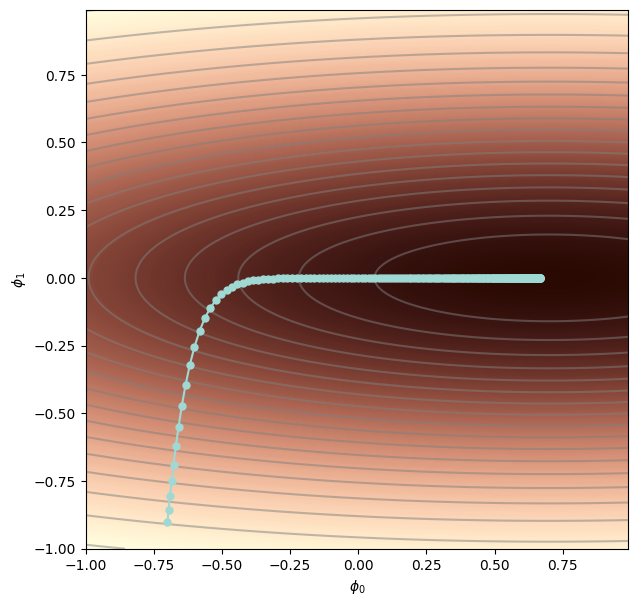

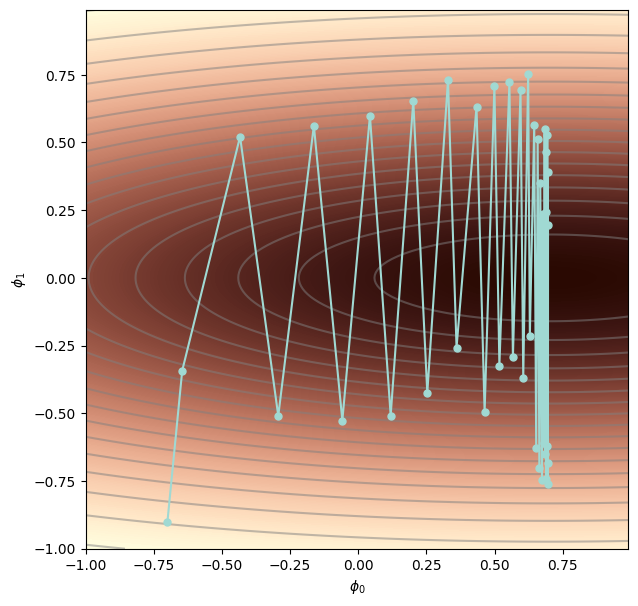

In [327]:
loss_function, phi0mesh, phi1mesh = get_loss_function_for_plot() ;

start_posn = np.zeros((2,1));
start_posn[0,0] = -0.7; start_posn[1,0] = -0.9

# Run gradient descent
grad_path1 = grad_descent(start_posn, n_steps=200, alpha = 0.08)
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path1)
grad_path2 = grad_descent(start_posn, n_steps=40, alpha= 1.0)
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path2)

Because the function changes much faster in $\phi_1$ than in $\phi_0$, there is no great step size to choose.  If we set the step size so that it makes sensible progress in the $\phi_1$ direction, then it takes many iterations to converge.  If we set the step size so that we make sensible progress in the $\phi_0$ direction, then the path oscillates in the $\phi_1$ direction.  

This motivates Adam.  At the core of Adam is the idea that we should just determine which way is downhill along each axis (i.e. left/right for $\phi_0$ or up/down for $\phi_1$) and move a fixed distance in that direction.

# Q5: TODO [15 Points]

Gradient descent with a fixed step size has the following undesirable property: it makes large adjustments to parameters associated with large gradients (where perhaps we should be more cautious) and small adjustments to parameters associated with small gradients (where perhaps we should explore further). When the gradient of the loss surface is much steeper in one direction than another, it is difficult to choose a learning rate that (i) makes good progress in both directions and (ii) is stable.

A straightforward approach is to normalize the gradients so that we move a fixed
distance (governed by the learning rate) in each direction. To do this, we first measure the gradient mt+1 and the pointwise squared gradient vt+1:

<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1l2hJobDH5BNqtL4fZMvwRAFrdlnikFw-)
Figure: 4
</center>


Then we apply the update rule:
<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1QE8FEpXQ9NmLOfYCiY8QCwXEypKE7bf9)
Figure: 5

</center>

where the square root and division are both pointwise, α is the learning rate, and ϵ is a small constant that prevents division by zero when the gradient magnitude is zero.

Let's implement it. Similar to momentum and nesterov momentum, complete the code given below.

In [328]:
def normalized_gradients(start_posn, n_steps, alpha,  epsilon=1e-20):
    grad_path = np.zeros((2, n_steps+1));
    grad_path[:,0] = start_posn[:,0];
    for c_step in range(n_steps):
        # Measure the gradient as in figure 4
        m = get_loss_gradient(grad_path[0,c_step], grad_path[1,c_step]);
        # TODO -- Use figure 4 and figure 5
        v = m ** 2
        m = m / (np.sqrt(v) + epsilon)
        grad_path[:,c_step+1] = grad_path[:,c_step] - alpha * m
        # END TODO
    return grad_path;

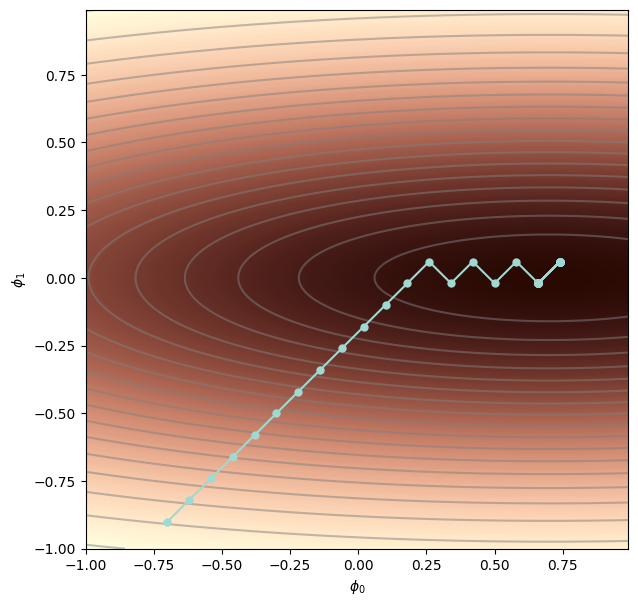

In [329]:
# Do Not Edit
# Use this Code for Testing
# Let's try out normalized gradients
start_posn = np.zeros((2,1));
start_posn[0,0] = -0.7; start_posn[1,0] = -0.9

# Run gradient descent
grad_path1 = normalized_gradients(start_posn, n_steps=40, alpha = 0.08)
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path1)

### If your code in this task is correct then your graph will look like this:


<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1j3BqNfEXwc-ZBM0VIkHBmf88qkZRy_1s)
Figure: 12
</center>


This moves towards the minimum at a sensible speed, but we never actually converge -- the solution just bounces back and forth between the last two points.  To make it converge, we add momentum to both the estimates of the gradient and the pointwise squared gradient.  We also modify the statistics by a factor that depends on the time to make sure the progress is not slow to start with.

# Q6: TODO [15 Points]


Good Job reaching till this point. You have learned various new things now.

Adaptive moment estimation, or Adam, takes this idea and adds momentum to both
the estimate of the gradient and the squared gradient:

<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1Wzv-3wYSVFgES2WZZNY4lETA9cd-QuQ5)
Figure: 7

</center>


where β and γ are the momentum coefficients for the two statistics.

Using momentum is equivalent to taking a weighted average over the history of each of these statistics. At the start of the procedure, all the previous measurements are effectively zero, resulting in unrealistically small estimates. Consequently, we modify these statistics using the rule:
<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1oRpUf1PU4Lfoa4PgcFCNhPcp9g2cvZ2B)
Figure: 8

</center>


Since β and γ are in the range [0, 1), the terms with exponents t+1 become smaller with each time step, the denominators become closer to one, and this modification has a diminishing effect.

Finally, we update the parameters as before, but with the modified terms:
<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1Z6IzxbcfcNmFJ4h3qNuUecI5KgRGdnCM)
Figure: 9

</center>


Let's complete the code for Adam Algorithm.





In [330]:
def adam(start_posn, n_steps, alpha,  beta=0.9, gamma=0.99, epsilon=1e-20):
    grad_path = np.zeros((2, n_steps+1));
    grad_path[:,0] = start_posn[:,0];
    m = np.zeros_like(grad_path[:,0])
    v = np.zeros_like(grad_path[:,0])
    for c_step in range(n_steps):
        # Measure the gradient
        grad = get_loss_gradient(grad_path[0,c_step], grad_path[1,c_step])
        # TODO -- Use figure 7, figure 8 and figure 9
        m = beta * m + (1-beta) * grad
        v = gamma * v + (1-gamma) * grad ** 2
        m_hat = m / (1 - beta ** (c_step+1))
        v_hat = v / (1 - gamma ** (c_step+1))

        grad_path[:,c_step+1] = grad_path[:,c_step] - alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        # END TODO

    return grad_path;

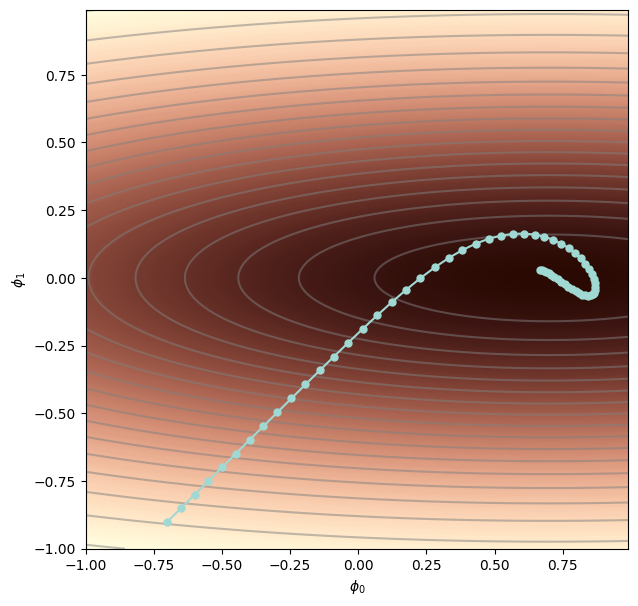

In [331]:
# Do Not Edit
# Use this Code for Testing
# Let's try out our Adam algorithm
start_posn = np.zeros((2,1));
start_posn[0,0] = -0.7; start_posn[1,0] = -0.9

# Run gradient descent
grad_path1 = adam(start_posn, n_steps=60, alpha = 0.05)
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path1)

### If your code in this task is correct then your graph will look like this:


<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1cRKUw8Nz7Br2cxxkF-6BW7OzKZOXIBxl)
Figure: 13
</center>


# **Backpropagation in Toy Model**

We will compute the derivatives of the toy function. We're going to investigate how to take the derivatives of functions where one operation is composed with another, which is composed with a third and so on.  For example, consider the model:

\begin{equation}
     \text{f}[x,\boldsymbol\phi] = \beta_3+\omega_3\cdot\cos\Bigl[\beta_2+\omega_2\cdot\exp\bigl[\beta_1+\omega_1\cdot\sin[\beta_0+\omega_0x]\bigr]\Bigr],
\end{equation}

with parameters $\boldsymbol\phi=\{\beta_0,\omega_0,\beta_1,\omega_1,\beta_2,\omega_2,\beta_3,\omega_3\}$.<br>

This is a composition of the functions $\cos[\bullet],\exp[\bullet],\sin[\bullet]$.   I chose these just because you probably already know the derivatives of these functions:

\begin{align}
 \frac{\partial \cos[z]}{\partial z} = -\sin[z] \quad\quad \frac{\partial \exp[z]}{\partial z} = \exp[z] \quad\quad \frac{\partial \sin[z]}{\partial z} = \cos[z].
\end{align}

Suppose that we have a least squares loss function:

\begin{equation*}
\ell_i = (\text{f}[x_i,\boldsymbol\phi]-y_i)^2,
\end{equation*}

Assume that we know the current values of $\beta_{0},\beta_{1},\beta_{2},\beta_{3},\omega_{0},\omega_{1},\omega_{2},\omega_{3}$, $x_i$ and $y_i$. We could obviously calculate $\ell_i$.   But we also want to know how $\ell_i$ changes when we make a small change to $\beta_{0},\beta_{1},\beta_{2},\beta_{3},\omega_{0},\omega_{1},\omega_{2}$, or $\omega_{3}$.  In other words, we want to compute the eight derivatives:

\begin{align}
\frac{\partial \ell_i}{\partial \beta_{0}}, \quad \frac{\partial \ell_i}{\partial \beta_{1}}, \quad \frac{\partial \ell_i}{\partial \beta_{2}}, \quad \frac{\partial \ell_i }{\partial \beta_{3}},  \quad \frac{\partial \ell_i}{\partial \omega_{0}}, \quad \frac{\partial \ell_i}{\partial \omega_{1}}, \quad \frac{\partial \ell_i}{\partial \omega_{2}},  \quad\text{and} \quad \frac{\partial \ell_i}{\partial \omega_{3}}.
\end{align}

Let's first define the original function for $y$ and the loss term:

In [332]:
def fn(x, beta0, beta1, beta2, beta3, omega0, omega1, omega2, omega3):
  return beta3+omega3 * np.cos(beta2 + omega2 * np.exp(beta1 + omega1 * np.sin(beta0 + omega0 * x)))

def loss(x, y, beta0, beta1, beta2, beta3, omega0, omega1, omega2, omega3):
  diff = fn(x, beta0, beta1, beta2, beta3, omega0, omega1, omega2, omega3) - y
  return diff * diff

Now we'll choose some values for the betas and the omegas and x and compute the output of the function:

In [333]:
beta0 = 1.0; beta1 = 2.0; beta2 = -3.0; beta3 = 0.4
omega0 = 0.1; omega1 = -0.4; omega2 = 2.0; omega3 = 3.0
x = 2.3; y = 2.0
l_i_func = loss(x,y,beta0,beta1,beta2,beta3,omega0,omega1,omega2,omega3)
print('l_i=%3.3f'%l_i_func)

l_i=0.139


# Computing derivatives by hand

We could compute expressions for the derivatives by hand and write code to compute them directly but some have very complex expressions, even for this relatively simple original equation. For example:

\begin{align}
\frac{\partial \ell_i}{\partial \omega_{0}} &=& -2 \left( \beta_3+\omega_3\cdot\cos\Bigl[\beta_2+\omega_2\cdot\exp\bigl[\beta_1+\omega_1\cdot\sin[\beta_0+\omega_0\cdot x_i]\bigr]\Bigr]-y_i\right)\nonumber \\
&&\hspace{0.5cm}\cdot \omega_1\omega_2\omega_3\cdot x_i\cdot\cos[\beta_0+\omega_0 \cdot x_i]\cdot\exp\Bigl[\beta_1 + \omega_1 \cdot \sin[\beta_0+\omega_0\cdot x_i]\Bigr]\nonumber\\
&& \hspace{1cm}\cdot \sin\biggl[\beta_2+\omega_2\cdot \exp\Bigl[\beta_1 + \omega_1 \cdot \sin[\beta_0+\omega_0\cdot x_i]\Bigr]\biggr].
\end{align}

In [334]:
dldbeta3_func = 2 * (beta3 +omega3 * np.cos(beta2 + omega2 * np.exp(beta1+omega1 * np.sin(beta0+omega0 * x)))-y)
dldomega0_func = -2 *(beta3 +omega3 * np.cos(beta2 + omega2 * np.exp(beta1+omega1 * np.sin(beta0+omega0 * x)))-y) * \
              omega1 * omega2 * omega3 * x * np.cos(beta0 + omega0 * x) * np.exp(beta1 +omega1 * np.sin(beta0 + omega0 * x)) *\
              np.sin(beta2 + omega2 * np.exp(beta1+ omega1* np.sin(beta0+omega0 * x)))

Let's make sure this is correct using finite differences:

In [335]:
dldomega0_fd = (loss(x,y,beta0,beta1,beta2,beta3,omega0+0.00001,omega1,omega2,omega3)-loss(x,y,beta0,beta1,beta2,beta3,omega0,omega1,omega2,omega3))/0.00001

print('dydomega0: Function value = %3.3f, Finite difference value = %3.3f'%(dldomega0_func,dldomega0_fd))

dydomega0: Function value = 5.246, Finite difference value = 5.246


The code to calculate $\partial l_i/ \partial \omega_0$ is a bit of a nightmare.  It's easy to make mistakes, and you can see that some parts of it are repeated (for example, the $\sin[\bullet]$ term), which suggests some kind of redundancy in the calculations.  The goal of this practical is to compute the derivatives in a much simpler way.  There will be three steps:

**Step 1:** Write the original equations as a series of intermediate calculations.

\begin{align}
f_{0} &=& \beta_{0} + \omega_{0} x_i\nonumber\\
h_{1} &=& \sin[f_{0}]\nonumber\\
f_{1} &=& \beta_{1} + \omega_{1}h_{1}\nonumber\\
h_{2} &=& \exp[f_{1}]\nonumber\\
f_{2} &=& \beta_{2} + \omega_{2} h_{2}\nonumber\\
h_{3} &=& \cos[f_{2}]\nonumber\\
f_{3} &=& \beta_{3} + \omega_{3}h_{3}\nonumber\\
l_i &=& (f_3-y_i)^2
\end{align}

and compute and store the values of all of these intermediate values.  We'll need them to compute the derivatives.<br>  This is called the **forward pass**.

# Q7: TODO [6 Points]

Compute all the f_k and h_k terms given below.

In [336]:
f0 = beta0 + omega0 * x
h1 = np.sin(f0)
f1 = beta1 + omega1 * h1
h2 = np.exp(f1)
f2 = beta2 + omega2 * h2
h3 = np.cos(f2)
f3 = beta3 + omega3 * h3
l_i = (f3 - y) * (f3 - y)


In [337]:
# Do Not Edit
# Use this Code for Testing
# Let's check we got that right:
print("f0: true value = %3.3f, your value = %3.3f"%(1.230, f0))
print("h1: true value = %3.3f, your value = %3.3f"%(0.942, h1))
print("f1: true value = %3.3f, your value = %3.3f"%(1.623, f1))
print("h2: true value = %3.3f, your value = %3.3f"%(5.068, h2))
print("f2: true value = %3.3f, your value = %3.3f"%(7.137, f2))
print("h3: true value = %3.3f, your value = %3.3f"%(0.657, h3))
print("f3: true value = %3.3f, your value = %3.3f"%(2.372, f3))
print("l_i original = %3.3f, l_i from forward pass = %3.3f"%(l_i_func, l_i))

assert np.round(f0,3)==1.230, "f0 is incorrect"
assert np.round(h1,3)==0.942, "h1 is incorrect"
assert np.round(f1,3)==1.623, "f1 is incorrect"
assert np.round(h2,3)==5.068, "h2 is incorrect"
assert np.round(f2,3)==7.137, "f2 is incorrect"
assert np.round(h3,3)==0.657, "h3 is incorrect"
assert np.round(f3,3)==2.372, "f3 is incorrect"
assert np.round(l_i,3)==np.round(l_i_func,3), "l_i is incorrect"


f0: true value = 1.230, your value = 1.230
h1: true value = 0.942, your value = 0.942
f1: true value = 1.623, your value = 1.623
h2: true value = 5.068, your value = 5.068
f2: true value = 7.137, your value = 7.137
h3: true value = 0.657, your value = 0.657
f3: true value = 2.372, your value = 2.372
l_i original = 0.139, l_i from forward pass = 0.139


**Step 2:** Compute the derivatives of $\ell_i$ with respect to the intermediate quantities that we just calculated, but in reverse order:

\begin{align}
\quad \frac{\partial \ell_i}{\partial f_3}, \quad \frac{\partial \ell_i}{\partial h_3}, \quad \frac{\partial \ell_i}{\partial f_2}, \quad
\frac{\partial \ell_i}{\partial h_2}, \quad \frac{\partial \ell_i}{\partial f_1}, \quad \frac{\partial \ell_i}{\partial h_1},  \quad\text{and} \quad \frac{\partial \ell_i}{\partial f_0}.
\end{align}

The first of these derivatives is straightforward:

\begin{equation}
\frac{\partial \ell_i}{\partial f_{3}} = 2 (f_3-y).
\end{equation}

The second derivative can be calculated using the chain rule:

\begin{equation}
\frac{\partial \ell_i}{\partial h_{3}} =\frac{\partial f_{3}}{\partial h_{3}} \frac{\partial \ell_i}{\partial f_{3}} .
\end{equation}

The left-hand side asks how $\ell_i$ changes when $h_{3}$ changes.  The right-hand side says we can decompose this into (i) how $\ell_i$ changes when $f_{3}$ changes and how $f_{3}$ changes when $h_{3}$ changes.  So you get a chain of events happening:  $h_{3}$ changes $f_{3}$, which changes $\ell_i$, and the derivatives represent the effects of this chain.  Notice that we computed the first of these derivatives already and is  $2 (f_3-y)$. We calculated $f_{3}$ in step 1.  The second term is the derivative of $\beta_{3} + \omega_{3}h_{3}$ with respect to $h_3$ which is simply $\omega_3$.  

We can continue in this way, computing the derivatives of the output with respect to these intermediate quantities:

\begin{align}
\frac{\partial \ell_i}{\partial f_{2}} &=& \frac{\partial h_{3}}{\partial f_{2}}\left(
\frac{\partial f_{3}}{\partial h_{3}}\frac{\partial \ell_i}{\partial f_{3}} \right)
\nonumber \\
\frac{\partial \ell_i}{\partial h_{2}} &=& \frac{\partial f_{2}}{\partial h_{2}}\left(\frac{\partial h_{3}}{\partial f_{2}}\frac{\partial f_{3}}{\partial h_{3}}\frac{\partial \ell_i}{\partial f_{3}}\right)\nonumber \\
\frac{\partial \ell_i}{\partial f_{1}} &=& \frac{\partial h_{2}}{\partial f_{1}}\left( \frac{\partial f_{2}}{\partial h_{2}}\frac{\partial h_{3}}{\partial f_{2}}\frac{\partial f_{3}}{\partial h_{3}}\frac{\partial \ell_i}{\partial f_{3}} \right)\nonumber \\
\frac{\partial \ell_i}{\partial h_{1}} &=& \frac{\partial f_{1}}{\partial h_{1}}\left(\frac{\partial h_{2}}{\partial f_{1}} \frac{\partial f_{2}}{\partial h_{2}}\frac{\partial h_{3}}{\partial f_{2}}\frac{\partial f_{3}}{\partial h_{3}}\frac{\partial \ell_i}{\partial f_{3}} \right)\nonumber \\
\frac{\partial \ell_i}{\partial f_{0}} &=& \frac{\partial h_{1}}{\partial f_{0}}\left(\frac{\partial f_{1}}{\partial h_{1}}\frac{\partial h_{2}}{\partial f_{1}} \frac{\partial f_{2}}{\partial h_{2}}\frac{\partial h_{3}}{\partial f_{2}}\frac{\partial f_{3}}{\partial h_{3}}\frac{\partial \ell_i}{\partial f_{3}} \right).
\end{align}

In each case, we have already computed all of the terms except the last one in the previous step, and the last term is simple to evaluate.  This is called the **backward pass**.

# Q8: TODO [8 Points]

Compute the derivatives of the output with respect to the intermediate computations h_k and f_k (i.e, run the backward pass). First 2 have been done. Complete the remaining ones.

In [338]:
dldf3 = 2* (f3 - y)
dldh3 = omega3 * dldf3
# Calculate the terms given below

dldf2 = dldh3 * -np.sin(f2)
dldh2 = dldf2 * omega2
dldf1 = dldh2 * np.exp(f1)
dldh1 = dldf1 * omega1
dldf0 = dldh1 * np.cos(f0)


In [339]:
# Do Not Edit
# Use this Code for Testing
# Let's check we got that right
print("dldf3: true value = %3.3f, your value = %3.3f"%(0.745, dldf3))
print("dldh3: true value = %3.3f, your value = %3.3f"%(2.234, dldh3))
print("dldf2: true value = %3.3f, your value = %3.3f"%(-1.683, dldf2))
print("dldh2: true value = %3.3f, your value = %3.3f"%(-3.366, dldh2))
print("dldf1: true value = %3.3f, your value = %3.3f"%(-17.060, dldf1))
print("dldh1: true value = %3.3f, your value = %3.3f"%(6.824, dldh1))
print("dldf0: true value = %3.3f, your value = %3.3f"%(2.281, dldf0))

assert np.round(dldf3,3)==0.745, "dldf3 is incorrect"
assert np.round(dldh3,3)==2.234, "dldh3 is incorrect"
assert np.round(dldf2,3)==-1.683, "dldf2 is incorrect"
assert np.round(dldh2,3)==-3.366, "dldh2 is incorrect"
assert np.round(dldf1,3)==-17.060, "dldf1 is incorrect"
assert np.round(dldh1,3)==6.824, "dldh1 is incorrect"
assert np.round(dldf0,3)==2.281, "dldf0 is incorrect"


dldf3: true value = 0.745, your value = 0.745
dldh3: true value = 2.234, your value = 2.234
dldf2: true value = -1.683, your value = -1.683
dldh2: true value = -3.366, your value = -3.366
dldf1: true value = -17.060, your value = -17.060
dldh1: true value = 6.824, your value = 6.824
dldf0: true value = 2.281, your value = 2.281


# Q9: TODO [6 Points]
Calculate the final derivatives with respect to the beta and omega terms

In [340]:
dldbeta3 = dldf3 * 1
dldomega3  = dldf3 * h3
dldbeta2 = dldf2 * 1
dldomega2 = dldf2 * h2
dldbeta1 = dldf1 * 1
dldomega1 = dldf1 * h1
dldbeta0 = dldf0 * 1
dldomega0 = dldf0 * x


In [341]:
# Do Not Edit
# Use this Code for Testing
# Let's check we got them right
print('dldbeta3: Your value = %3.3f, True value = %3.3f'%(dldbeta3, 0.745))
print('dldomega3: Your value = %3.3f, True value = %3.3f'%(dldomega3, 0.489))
print('dldbeta2: Your value = %3.3f, True value = %3.3f'%(dldbeta2, -1.683))
print('dldomega2: Your value = %3.3f, True value = %3.3f'%(dldomega2, -8.530))
print('dldbeta1: Your value = %3.3f, True value = %3.3f'%(dldbeta1, -17.060))
print('dldomega1: Your value = %3.3f, True value = %3.3f'%(dldomega1, -16.079))
print('dldbeta0: Your value = %3.3f, True value = %3.3f'%(dldbeta0, 2.281))
print('dldomega0: Your value = %3.3f, Function value = %3.3f, Finite difference value = %3.3f'%(dldomega0, dldomega0_func, dldomega0_fd))

assert np.round(dldbeta3,3)==0.745, "dldbeta3 is incorrect"
assert np.round(dldomega3,3)==0.489, "dldomega3 is incorrect"
assert np.round(dldbeta2,3)==-1.683, "dldbeta2 is incorrect"
assert np.round(dldomega2,3)==-8.530, "dldomega2 is incorrect"
assert np.round(dldbeta1,3)==-17.060, "dldbeta1 is incorrect"
assert np.round(dldomega1,3)==-16.079, "dldomega1 is incorrect"
assert np.round(dldbeta0,3)==2.281, "dldbeta0 is incorrect"
assert np.round(dldomega0,3)==np.round(dldomega0_func,3), "dldomega0 is incorrect"

dldbeta3: Your value = 0.745, True value = 0.745
dldomega3: Your value = 0.489, True value = 0.489
dldbeta2: Your value = -1.683, True value = -1.683
dldomega2: Your value = -8.530, True value = -8.530
dldbeta1: Your value = -17.060, True value = -17.060
dldomega1: Your value = -16.079, True value = -16.079
dldbeta0: Your value = 2.281, True value = 2.281
dldomega0: Your value = 5.246, Function value = 5.246, Finite difference value = 5.246


Using this method, we can compute the derivatives quite easily without needing to compute very complicated expressions.  In the next lab, we'll apply this same method to a deep neural network.

# Ungraded

Since you are at the end of the lab, you can utilize this time to answer some questions in the lab or at home.

Go to Q2 and Experiment with different learning rates, starting points, batch sizes, number of steps.  Additionally, add a learning rate schedule.  Reduce the learning rate by a factor of beta every M iterations